In [67]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

# including fastai stuff just in case we want it.

from fastai.imports import *
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title

def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

def combine_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
              seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def is_date(x): return np.issubdtype(x.dtype, np.datetime64)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

def get_nn_mappers(df, cat_vars, contin_vars):
    # Replace nulls with 0 for continuous, "" for categorical.
    for v in contin_vars: df[v] = df[v].fillna(df[v].max()+100,)
    for v in cat_vars: df[v].fillna('#NA#', inplace=True)

    # list of tuples, containing variable and instance of a transformer for that variable
    # for categoricals, use LabelEncoder to map to integers. For continuous, standardize
    cat_maps = [(o, LabelEncoder()) for o in cat_vars]
    contin_maps = [([o], StandardScaler()) for o in contin_vars]
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
PATH = "data/house_prices/"

# Loading data

In [159]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [160]:
# Light processing to get log dependent var and categorical variables
df_raw['SalePrice'] = np.log(df_raw.SalePrice)
train_cats(df_raw)

In [161]:
df_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [162]:
# Store data in feather format for faster recovery on kernel restart.
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/house-raw')

# Model 1: Naive random forest

This is the first model, a naive Random Forest with zero processing done except to convert categorical values to numeric.

In [121]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [122]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 200
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1260, 83), (1260,), (200, 83), (200,))

In [123]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 303 ms, sys: 22.1 ms, total: 325 ms
Wall time: 135 ms
[0.06308405009136586, 0.16730492507497907, 0.975236527230168, 0.8153213881564726]


# Explore: Initial Feature exploration

In [124]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
17,OverallQual,0.542055
46,GrLivArea,0.104634
38,TotalBsmtSF,0.049831
61,GarageCars,0.038023
62,GarageArea,0.030631
43,1stFlrSF,0.025601
34,BsmtFinSF1,0.020219
18,OverallCond,0.018513
4,LotArea,0.013925
19,YearBuilt,0.011979


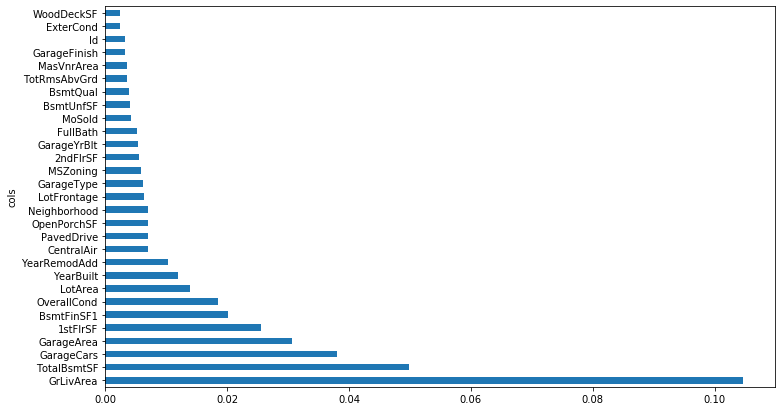

In [125]:
plot_fi(fi[1:30]);

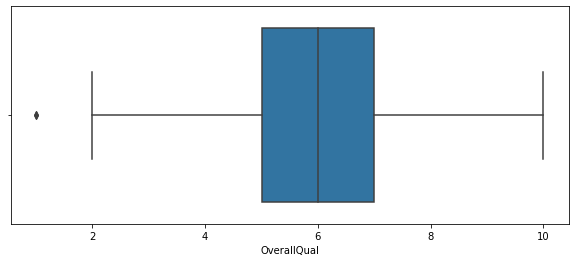

In [126]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_raw.OverallQual)

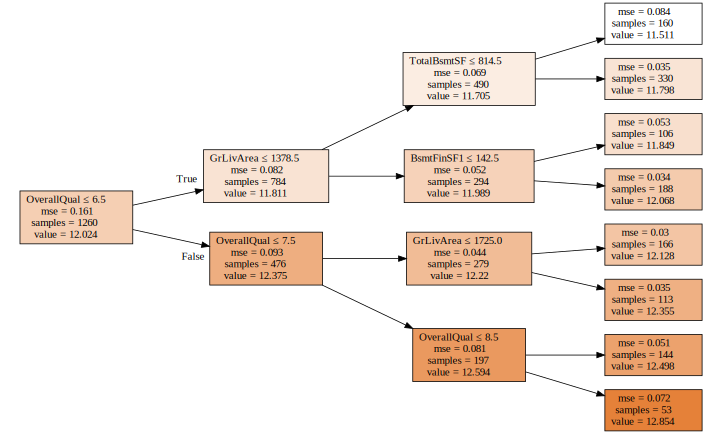

In [127]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
draw_tree(m.estimators_[0], X_train, precision=3)

In [133]:
to_keep = fi[fi.imp>0.002].cols; len(to_keep)
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
len(to_keep)

32

In [134]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/home/robwilliams42/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.06379100907357224, 0.15425280627409374, 0.9746783875647207, 0.8430124190382939, -7.453617895199448]


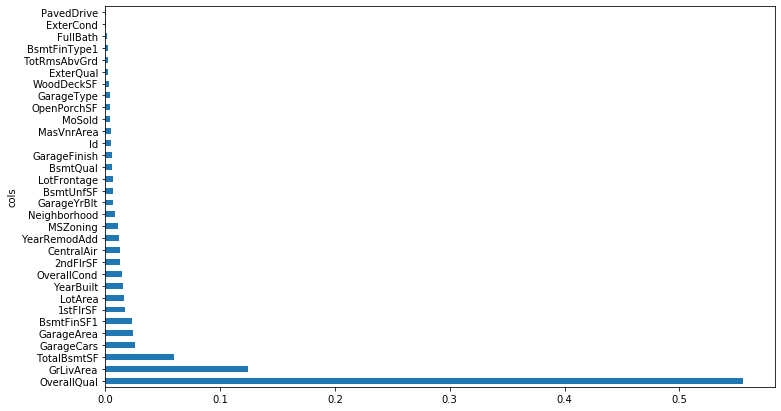

In [135]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# Model 2. One hot encoding

In [136]:
df, y, nas = proc_df(df_raw, 'SalePrice', max_n_cat=10)

In [137]:
n_valid = 200
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1260, 279), (1260,), (200, 279), (200,))

In [138]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.78 s, sys: 49.5 ms, total: 1.83 s
Wall time: 594 ms
[0.05423370264051627, 0.15366865172911512, 0.9816974785561597, 0.8441991898718098, 0.8637201927502287]


# Explore: Feature importance and redundant feature removal

The idea was to remove redundant features, but it seems the RF is making good use of all the features, so I decided to just keep them.

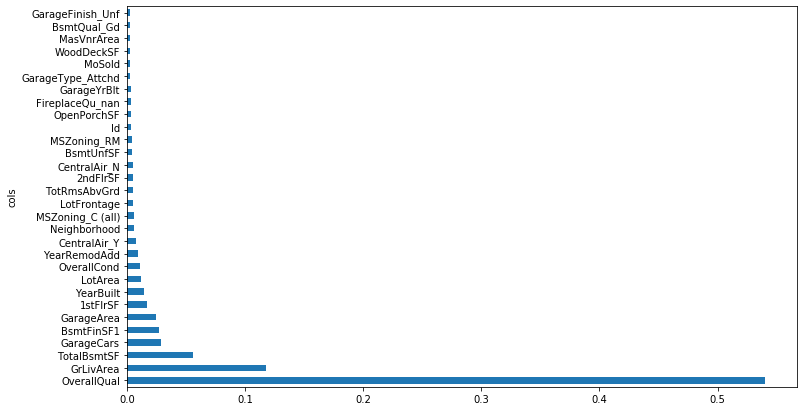

In [142]:
fi = rf_feat_importance(m, df)
plot_fi(fi[:30]);

In [151]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
len(to_keep)

17

In [152]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 464 ms, sys: 19.3 ms, total: 483 ms
Wall time: 249 ms
[0.05403700352025659, 0.15141672184535093, 0.9818299998904951, 0.8487320821794848, 0.8717549790058962]


In [104]:
from scipy.cluster import hierarchy as hc

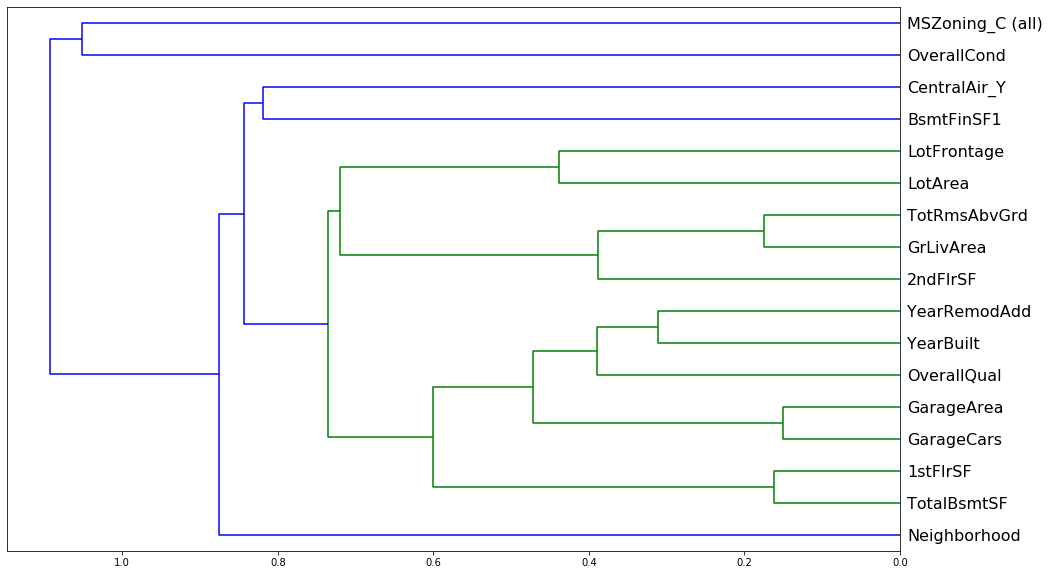

In [153]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

# Hyperparameter tuning

Deciding the best parameters...

In [111]:
# Hyperparameter tuning
print('Trying various n_estimators values')
for n in [10, 20, 40, 80, 100]:
    print(f'n_estimators={n}')
    m = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    m.fit(X_train, y_train)
    print_score(m)
print('Trying various min_samples_leaf values')
for n in [1, 3, 5, 10, 25]:
    print(f'min_samples_leaf={n}')
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1, min_samples_leaf=n)
    m.fit(X_train, y_train)
    print_score(m)
print('Trying various max_features values')
for n in [None, 0.5, 0.25, 'sqrt', 'log2']:
    print(f'max_features={n}')
    m = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_features=n)
    m.fit(X_train, y_train)
    print_score(m)

Trying various n_estimators values
n_estimators=10
[0.06739869465569215, 0.16053032552767824, 0.9717332821426683, 0.8299747889387556]
n_estimators=20
[0.058677938684482414, 0.15863037714967002, 0.9785749368263932, 0.8339756213856557]
n_estimators=40
[0.05247558235822841, 0.1556405689894022, 0.9828648880135329, 0.8401749792306762]
n_estimators=80
[0.05324035318877816, 0.15622186631447144, 0.982361799750217, 0.8389788983718643]
n_estimators=100
[0.05154855435591831, 0.15389733014798412, 0.9834649545195752, 0.843735142166355]
Trying various min_samples_leaf values
min_samples_leaf=1
[0.06118759188163727, 0.16620580681901526, 0.9767030463411122, 0.8177399287702]
min_samples_leaf=3
[0.0807228118299301, 0.16569088233390578, 0.9594524165881549, 0.8188675042246814]
min_samples_leaf=5
[0.0974556593029097, 0.1815175271930899, 0.9409001279005309, 0.7826116416133533]
min_samples_leaf=10
[0.12200892338634671, 0.17543744273434891, 0.9073691598622161, 0.7969309550363817]
min_samples_leaf=25
[0.152114

In [196]:
df_ext = df.copy()
x, y, nas = proc_df(df_ext, 'OverallQual')

In [197]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.5678082191780822

In [198]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
6,YearBuilt,0.084418
135,ExterQual_TA,0.061342
29,GarageArea,0.057199
18,GrLivArea,0.049421
14,TotalBsmtSF,0.045473
15,1stFlrSF,0.035664
0,Id,0.031936
10,MasVnrArea,0.029830
13,BsmtUnfSF,0.028241
16,2ndFlrSF,0.027961


In [203]:
df_raw.BsmtQual

0        Gd
1        Gd
2        Gd
3        TA
4        Gd
5        Gd
6        Ex
7        Gd
8        TA
9        TA
10       TA
11       Ex
12       TA
13       Gd
14       TA
15       TA
16       TA
17      NaN
18       TA
19       TA
20       Ex
21       TA
22       Gd
23       Gd
24       TA
25       Gd
26       TA
27       Ex
28       TA
29       TA
30       TA
31       TA
32       Ex
33       TA
34       Ex
35       Ex
36       Gd
37       TA
38       TA
39      NaN
40       TA
41       TA
42       Gd
43       Gd
44       TA
45       Ex
46       Ex
47       Gd
48       TA
49       TA
50       Gd
51       TA
52       Gd
53       Ex
54       TA
55       TA
56       Gd
57       Gd
58       Ex
59       TA
60       Gd
61       TA
62       Gd
63       TA
64       Gd
65       Ex
66       Gd
67       Gd
68       TA
69       TA
70       Gd
71       TA
72       Gd
73       TA
74       Fa
75       Gd
76       TA
77       TA
78       TA
79       TA
80       Gd
81       Ex
82       Gd
83  

In [191]:
x.drop('Id', axis=1, inplace=True)

In [192]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.8582191780821918

In [193]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
2,LotArea,0.066417
13,BsmtUnfSF,0.051477
18,GrLivArea,0.045656
29,GarageArea,0.042744
37,MoSold,0.036103
11,BsmtFinSF1,0.035531
1,LotFrontage,0.034438
31,OpenPorchSF,0.034299
27,GarageYrBlt,0.033903
14,TotalBsmtSF,0.033868


# Running final model

In [194]:
df_raw = pd.read_feather('tmp/house-raw')
df, y, nas = proc_df(df_raw, 'SalePrice', max_n_cat=10)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1260, 279), (1260,), (200, 279), (200,))

In [179]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_features=0.5, min_samples_leaf=1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4.91 s, sys: 85.4 ms, total: 5 s
Wall time: 1.59 s
[0.05035593693802112, 0.14367050783174945, 0.9842212071293134, 0.8638133918178736, 0.8827410349963118]


# Submission

In [180]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [181]:
apply_cats(df_test, df_raw)

In [182]:
df_real, _, _ = proc_df(df_test, na_dict=nas, max_n_cat=10)

In [183]:
submission = pd.DataFrame({'Id': df_real['Id'], 'SalePrice': np.e ** m.predict(df_real)})
submission.head()

,Id,SalePrice
0,1461,122783.210061
1,1462,149607.139922
2,1463,176410.665463
3,1464,185285.870159
4,1465,194175.263401


In [184]:
submission.to_csv(f'{PATH}real_submission.csv', index=False)